# Cognitive Modelling - Tutorial 1 - Part 1
Anne Urai, 2024
Thanks to Alexandre Hyafil, BAMB 2024

# Introduction

<font color='blue'>
In this tutorial, we will cover all the steps involved in modelling behavioral data, from formalizing your hypotheses into a computational model to comparing which model is best supported by the data, using a toy example from a sensory discrimination task. The idea is to map all the types of analyses we may want to perform on behavioral data, before we address in the following days how to perform these analyses for more complex models. More specifically we will cover

- **Model definition**: from box diagram to a statistical description
- **Model simulation**: to understand how the model behaves
- **Model estimation**: fitting model parameters to a behavioral dataset, and assessing the uncertainty about these parameter estimates
- **Model validation**: checking whether a fitted model reproduces the key qualitative features of the dataset
- **Model comparison**: comparing which model better accounts for experimental data
- **Model and parameter recovery**: estimating how well we can estimate model parameters or discriminate between models using a particular behavioral paradigm

In this first part of the tutorial, we will cover model definition, simulation and estimation.

Our behavioral dataset corresponds to a standard two-alternative forced-choice task, where on each trial subjects have to report on the direction of motion of a stimulus with a binary response (left or right). The stimulus strength (or stimulus evidence) is varied across trial. Crucially, in a random subset of trials, brain area X is deactivated (through optogenetics/TMS), leading to a decrease in task performance. Our data is thus composed of one dependent variable (choice $r$, binary, say L/R) and two independent variables:
- stimulus evidence $s$ (signed, distributed between 9 values)
- condition $c$ (binary, 'default' or 'manipulation')

Here's the question we want to address with our modelling exercice: **is the deactivation affecting stimulus processing or purely decision-making abilities?** In the latter case, deactivating brain area X would not cause any change in stimulus processing, but would promote random responses unrelated to the sensory percept (i.e. 'lapses') in a subset of trials.</font>

## Summary statistics: the psychometric curve
Before starting to define our models, we need to specify what characteristics of the experimental data we expect them to capture. This often corresponds to summary statistics, i.e. the average value of the behavioral variable in different sets of trials (different experimental conditions). In the case of sensory tasks with binary choices, we usually extract the **psychometric curve**, corresponding to the proportion of rightward choices as a function of stimulus evidence. We plot the psychometric curve below, separately for control trials and deactivation trials. This change of the relationship between stimulus and choice is precisely what we expect our model to capture.

In [41]:
# first, import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as optimize
import ipywidgets as widgets       # interactive display

In [42]:
# load the data
#df_exp = pd.read_csv("https://raw.githubusercontent.com/bambschool/BAMB2023/main/1-modeling_101/dataset_tutorial1.csv?token=GHSAT0AAAAAACFH2I2TUEKMMHZMREHILHOUZFXCWCA")
df_exp = pd.read_csv("dataset_tutorial1.csv")
df_exp.head()

,Unnamed: 0,stimulus,condition,response
0,0,0.0,manipulation,0
1,1,-2.0,manipulation,0
2,2,3.0,control,1
3,3,2.0,control,1
4,4,1.0,control,1


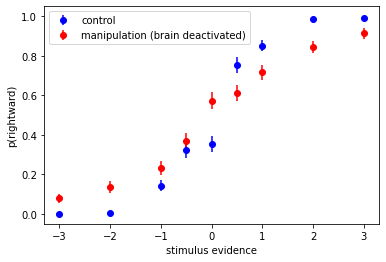

In [43]:
#define function to plot psychometric curve for dataset separately for control trials and deactivation trials
def plot_data_psychometric(df):
    """
    Plots the psychometric function separately for control and deactivation trials.
    Args:
       df (dataframe): dataset.
    """
    # plot psychometric curve for control trials
    mask = df.condition=='control' # select control trials
    df[mask].groupby('stimulus').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'bo', ax=plt.gca(), legend=False);

    # plot psychometric curve for manipulation trials
    mask = df.condition=='manipulation' # select manipulation trials
    df[mask].groupby('stimulus').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'ro', ax=plt.gca(), legend=False);

    plt.legend(('control','manipulation (brain deactivated)'));
    plt.xlabel('stimulus evidence');
    plt.ylabel('p(rightward)');

# apply the function on the experimental dataframe
plot_data_psychometric(df_exp)

# PART I

In this first part of the tutorial, we will cover **three modelling steps: model definition, model simulations and model estimation**.

# 1. Model definition
<font color='blue'>
We want to define two models, where each model embodies one of the two hypotheses:
- **model A**: the manipulation affects stimulus processing
- **model B**: the manipulation leads to a certain proportion of lapses

Both of these models should take the stimulus evidence and experimental condition (*manipulation* vs. *control*) as input and output the binary choice.
We will follow two successive steps in order to derive a complete statistical description for each of these models.


## 1.1 Box diagram description

First, for each of the two models, draw a box diagram describing how responses are produced and how the experimental manipulation interferes with this production, according to that model. Each diagram should feature boxes describing the causal interaction between the dependent and independent variables (the *observed variables*), and possibly other non-measured variables (the *unobserved variables* or *latent variables*). (Following conventions for Probabilistic Graphical Models, we can colour the observed variable in grey, and leave boxes for latent variables in white).
</font>

What other variables could we introduce?

## 1.2 Statistical model: signal detection theory

Now, in order to be fitted to actual data, we need a **statistical model of behavior**, whereby the modelled behavior (here binary choices) is a stochastic variable that depends on our dependent variables. Here, because the output is binary, each statistical model is described by an equation linking the probability for the binary response (say rightwards responses) as a function of the dependent variables (stimulus and manupulation). To do so, we need to formalize each model one step further by expliciting in our box diagram how each variable in a box is computed from the value of the other variables (through a deterministic or probabilistic relationship to the variables that influence it).

We will use signal-detection theory (SDT) to turn each diagram into a statistical description. In SDT, the perceived stimulus evidence (or percept) is simply the value of the true stimulus evidence (set by the experimenter) corrupted by some gaussian noise:
$\hat s = s + \epsilon$ where $\epsilon$ is gaussian noise of variance $\sigma^2$.
The decision is taken from the position of $\hat s$ w.r.t a threshold $T$. As the noise variance goes larger, the psychometric curve gets shallower and the accuracy of the model deteriorates.

In model A, we assume different noise levels in the two conditions ($\sigma^2_d$ and $\sigma^2_m$), corresponding to different precisions of sensory encoding.
In model B, we assume that the noise variance is not affected by the manipulation. However, in deactivation trials, with a probability $\lambda$, the decision is not based on the stimulus but randomly drawn (with probability $q$ giving response R, probability $1-q$ giving response L).

We now see the **parameter set $\theta$** for each model:
- $T$, $\sigma^2_d$ and $\sigma^2_m$ in model A
- $T$, $\sigma^2_d$, $\lambda$ and $q$ in model B

To simplify things, we will assume no particular bias between L and R responses, so $T=0$ and $q=0.5$. Note that in this case both models have only two free parameters, there are thus equated in terms of complexity.

We will focus on model B for the sake of time. Adapting the analyses for model A is left as optional.

# PART I - 2. Model simulations

## 2.1 Simulate


In [44]:
# Define a function that simulates model B

def simulate_modelB(s, c, sigma_d=1, Lambda=0.2, T=0, q=0.5):
    """
    Simulates model B (proportion of lapses provoked by deactivation).
    Args:
        s (list): sensory evidence, for each trial
        c (list): experimental condition, for each trial
        sigma_d (scalar): variance of the sensory noise
        Lambda (scalar): probability of lapse trial
        T (scalar): threshold
        q (scalar): probability of rightward choice for a lapse trial
    Returns
        list: binary choice, for each trial
    """
    n = len(s) # number of trials


    # noisy stimulus (or percept), i.e. true stimulus evidence contaminated by noise
    s_hat = s + np.random.normal(0, sigma_d, n )

    # binary response based on stimulus (1 if noisy stimulus is above threshold, 0 otherwise)
    r_stim = np.where(s_hat>T, 1, 0)

    # generate boolean array (True if lapse; only in Manipulation trials)
    isLapse = np.random.choice(a=[1, 0], p=[Lambda, 1 - Lambda], size=n)

    # lapse responses (if lapse trial)
    r_lapse = np.random.choice(a=[0, 1], p=[q, 1 - q], size=n)
    manipultaed = np.where(c==0, 1, 0)
    index_lapse = np.where(isLapse + manipultaed > 1, 1, 0)
    # final binary response (lapse response if lapse trial, sensory-based response otherwise)
    r = np.where( index_lapse==1, r_lapse, r_stim)
    return r


Use the function above to simulate model B (with model parameters defined below) on the same set of the trials as the experimental dataset.
(Note: it is important to compare simulations with the exact same set of trials as the original dataset to facilitate comparison)

In [63]:
# parameters of model B
T = 0 #decision threshold
sigma = 1 # decision noise
Lambda = .2 # proportion of lapses
q = 0.5 # probability of rightward response if lapse

#use generate experimental conditions from actual dataset
c = df_exp['condition'] # condition
s = df_exp['stimulus'] #stimulus evidence

#simulate model
r = simulate_modelB(s, c, sigma_d=sigma, Lambda=Lambda, T=T, q=q)

# create dataframe for simulated data
df_modelB = pd.DataFrame({'stimulus': s, 'condition':c, 'response':r})
df_modelB.head()

,stimulus,condition,response
0,0.0,manipulation,1
1,-2.0,manipulation,0
2,3.0,control,1
3,2.0,control,1
4,1.0,control,1


## 2.2 Simulated psychometric curve
Now plot the psychometric curve, separately for each condition, for the data simulated from model B.

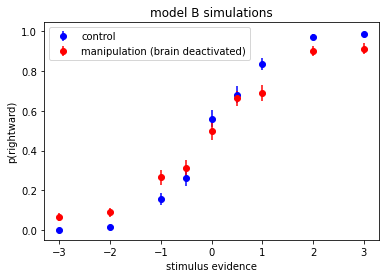

In [64]:
plot_data_psychometric(df_modelB)
plt.title('model B simulations');

In [65]:
# Define a function that simulates model A
def simulate_modelA(s, c, sigma_d=1, sigma_m=1.5, T=0):
    """
    Simulates model A (change in sensory noise with deactivation).
    Args:
        s (list): sensory evidence, for each trial
        c (list): experimental condition, for each trial
        sigma_d (scalar): variance of the sensory noise in control trials
        sigma_m (scalar): variance of the sensory noise in deactivation trials
        T (scalar): threshold
    Returns 
        list: binary choice, for each trial
    """
    n = len(s)

    # variance of noise for each trial
    sigma = np.where( c=='control', sigma_d, sigma_m)

    # noisy stimulus (or percept), i.e. true stimulus evidence contaminated by noise
    s_hat = s + np.random.normal(0, sigma, n )

    # binary response (1 if noisy stimulus is above threshold, 0 otherwise)
    r = np.where(s_hat>T, 1, 0)  # Response based on stimulus (SDT)
    return r


In [48]:
# parameters of model A
T = 0 #decision threshold
sigma_d = 1 # decision noise
sigma_m = 2 # proportion of lapses


#use generate experimental conditions from actual dataset
c =df_exp['condition'] # condition
s = df_exp['stimulus'] #stimulus evidence

#simulate model
r = simulate_modelA(s, c, sigma_d=sigma_d, sigma_m=sigma_m, T=T)

df_modelA = pd.DataFrame({'stimulus': s, 'condition':c, 'response':r})

df_modelA.head()

,stimulus,condition,response
0,0.0,manipulation,1
1,-2.0,manipulation,0
2,3.0,control,1
3,2.0,control,1
4,1.0,control,0


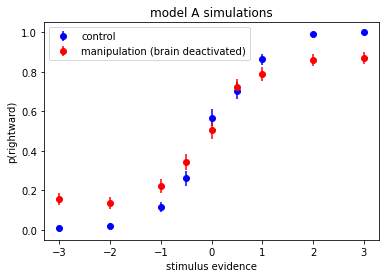

In [49]:
plot_data_psychometric(df_modelB)
plt.title('model A simulations');

# PART I - 3. Model estimation

We are lucky that in both models we can formulate analytically the statistical link between the observed variable (response) and the conditions.
In simple signal detection theory, $p(r=1|s) = \int_{\hat s} p(r=1|\hat s)p(\hat s|s)d\hat s = \int_{\hat s>T} \mathcal N(\hat s;s,\sigma^2)d\hat s=\Phi( \frac{s-T}{\sigma})$ where $\Phi$ is the cumulative standard normal function.

So for model B (in deactivation trials): $p_B(r=1|s) = (1-\lambda)\Phi( \frac{s}{\sigma}) + \lambda/2$

## 3.1 Naive fitting

A naive fitting procedure consists in adjusting manually the parameters in each model to try to visually match the experimental and theoretical psychometric curves. Here we just adjust the parameters by hand so that the predicted value captures the summary statistics qualitatively.
To do so, first, define a function that computes the probability of a rightward choice according to model B as a function of stimulus evidence and experimental condition. Then define another function which uses this function to plot the theoretical psychometric curves according to model B, now at all continuous valus of stimulus evidence between -3 and 3 (and not just the 9 discrete values explored in the dataset). One of the benefit of using a statistical model is to draw predictions for experimental conditions not seen in the original dataset.

In [50]:
# define probability of rightward choices according to model B (using equations above)

def p_modelB(s,c, sigma_d, Lambda):
    """
    Computes the probability of rightward choices according to model B
    Args:
        s (list): sensory evidence, for each trial
        c (list): experimental condition, for each trial
        sigma_d (scalar): variance of the sensory noise
        Lambda (scalar): probability of lapse trial
    Returns:
        list: probability of rightward choice, for each trial
    """
    # probability of rightward choice if control trial
    p_ctrl = norm.cdf((s)/sigma_d)

    # probability of rightward choice if manipulated condition
    p_manip = Lambda/2 + (1-Lambda)*norm.cdf((s)/sigma_d)

    # probability of rightward choice in control and manipulated condition
    p = np.where(c=='control', p_ctrl, p_manip)
    return p


# Plot psychometric curve at continuous values, for given model
def plot_model(p_model):
    """
    Args:
        p_model (function): computes the probability of rightward choices according to corresponding model
    """
    # define 100 angle points linearly spaced between -3 and 3
    s_linspace = np.linspace(-3,3,100)

    p_standard = p_model(s_linspace,'control')
    p_manipulation = p_model(s_linspace,'manipulation')

    # plot fitted psychometric functions
    plt.plot(s_linspace, p_standard, 'b', label="control")
    plt.plot(s_linspace, p_manipulation, 'r', label="manipulation")

    plt.ylabel('p(rightward)')

Now use the widget below to adjust parameters to yield the best possible fit between experimental and theoretical psychometric curves. Is the fit good enough?

In [51]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(
    sigma_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0), # default, min and max values for noise variance param
    Lambda_hat=widgets.FloatSlider(0.5, min=0.0, max=1.0)) # defaul, min and max values for lapse parameter

def plot_data_estimate(sigma_hat, Lambda_hat):

    # anonymous function taking stimulus and condition as argument, and computing the proba of response according to model
    p_modelB_fun = lambda s1,c1: p_modelB(s1, c1, sigma_d=sigma_hat, Lambda=Lambda_hat)

    # plot model predictions
    plot_model(p_modelB_fun)

    # plot psychometric curve on top
    plot_data_psychometric(df_exp)

    plt.title('model B');
    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=1.0, description='sigma_hat', max=2.0), FloatSlider(value=0.5, descrip…

(Optional) Repeat the same for model A.

In [52]:
# define probability of rightward choices according to model A (using equations above)
def p_modelA(s,c, sigma_d, sigma_m):
    """
    Computes the probability of rightward choices according to model A
    Args:
        s (list): sensory evidence, for each trial
        c (list): experimental condition, for each trial
        sigma_d (scalar): variance of the sensory noise in control trials
        sigma_m (scalar): variance of the sensory noise in deactivation trials
    Returns:
        list: probability of rightward choice, for each trial
    """
    # probability of rightward choice if control trial
    p_ctrl = norm.cdf((s)/sigma_d)

    # probability of rightward choice if manipulated condition
    p_manip = norm.cdf((s)/sigma_m)

    # probability of rightward choice in control and manipulated condition
    p = np.where(c=='control', p_ctrl, p_manip)
    return p
   

In [53]:
@widgets.interact(
    sigma_d_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0),
    sigma_m_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))


def plot_data_estimate(sigma_d_hat, sigma_m_hat):

    # plot model predictions
    plot_modelA_fun = lambda s,c: p_modelA(s,c,sigma_d=sigma_d_hat, sigma_m=sigma_m_hat)

    # plot psychometric curve on top
    plot_model(plot_modelA_fun)
    plot_data_psychometric( df_exp )

    plt.title('model A');
    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=1.0, description='sigma_d_hat', max=2.0), FloatSlider(value=1.0, descr…

## 3.2 Likelihood function
Now we will use a more principled approach to parameter estimation by looking for the set of parameters that maximize a given metric, namely the **log-likelihood** of the data. The likelihood function is a function, defined for a given model and dataset, that takes the **parameters as input**.
Complete the following function to compute the log-likelihood of model for a given set of parameters.

In [54]:
def LogLikelihood_modelB(df, sigma_d, Lambda):
    """
    Computes the log-likelihood of model B with certain parameter set
    Args:
        df (dataframe): dataset
        c (list): experimental condition, for each trial
        sigma_d (scalar): variance of the sensory noise
        Lambda (scalar): probability of lapse trial
    Returns:
        scalar: log-likelihood of model B
    """
    # p of rightward choice for each trial in dataset, according to model B
    p = p_modelB(df['stimulus'], df['condition'], sigma_d, Lambda)

    # likelihood for each trial (=p if choice is rightward, 1-p otherwise)
    lh = np.where(df['response']==1, p, 1-p)

    # Handle division by zero
    lh = np.where(lh == 0, np.finfo(float).eps, lh)

    # log-likelihood for whole dataset (sum of log-likelihood of individual trials)
    LLH = np.sum(np.log(lh))

    return LLH

Compute the log-likelihood of model B at the values of the parameters obtained by naive fitting.

In [55]:
llh_B = LogLikelihood_modelB(df_exp, 0.9, 0.3)
print(llh_B)

-1039.9934789612719


## 3.3 Maximum likelihood estimation

Now that we have a function of parameters that defines a metric for how well the model accounts for the data, we will look for the parameter space in search for the parameter set that maximizes this metric.
First, plot the value of the LLH as a function of both parameters, as a coloured plot.

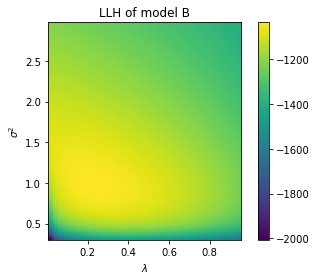

In [56]:
# define linearly space values of Lambda and sigma
Lambda = np.arange(0.005, 0.96, 0.025)
sigma = np.arange(0.3, 3.0, 0.025)

# compute all possible pairs of parameter values (defining a grid)
LL, ss = np.meshgrid(Lambda, sigma)

# compute LLH for each of these parameter sets
LLH = np.zeros(LL.shape)
for j in range(LL.shape[0]):
    for k in range(LL.shape[1]):
        LLH[j,k] = LogLikelihood_modelB(df_exp, sigma[j], Lambda[k])

# define function to plot Log-Likelihood profile
def show_LL(LLH,Lambda,sigma):
    im=plt.imshow(np.flipud(LLH), extent=[Lambda[0],Lambda[-1],sigma[0],sigma[-1]]);
    plt.gca().set_aspect(0.4)
    plt.ylabel('$\sigma^2$')
    plt.xlabel('$\lambda$')
    plt.colorbar(im)

show_LL(LLH,Lambda,sigma)
plt.title('LLH of model B');

Finally, we can identify the maximum-likelihood parameters by using an optimization algorithm over the LLH function. Because most optimization tools are defined for minimization rather than maximization, we will actually minimize the negative Log-Likelihood (which is equivalent to maximize the LLH).

In [57]:
# Define the objective function (the to be maximized)
def neg_llh_modelB(pp, df):
    """
    Computes the neg-LLH for model B.
    Args:
        - pp (list): set of parameters (sigma_d,Lambda)
        - df (dataframe): dataset
    Returns;
        - scalar: negative LLH
    """
    return -LogLikelihood_modelB(df, pp[0], pp[1])


# Define the bounds for each variable
bounds = [(0.1, 10), (0.01, 1)]  # Example bounds: both variables are between 0 and 1

# Initial guess for parameter set
x0 = [0.75, 0.5]

# Perform the optimization with bounds
result = optimize.minimize(neg_llh_modelB, x0=x0, args=(df_exp), bounds=bounds)

# Retrieve the optimized parameters
(sigma_hat, Lambda_hat) = result.x

# print
print("sigma_hat^2 =",sigma_hat)
print("Lambda_hat =",Lambda_hat)

sigma_hat^2 = 0.9770947319889381
Lambda_hat = 0.22677752682176988


Add the maximum likelihood parameters as a red dot on the LLH profile.

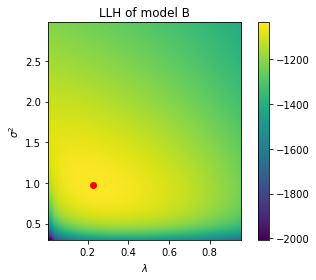

In [58]:
# plot LLH profile
show_LL(LLH,Lambda,sigma)
plt.title('LLH of model B');
plt.plot(Lambda_hat, sigma_hat, 'ro')


# add MLE parameters as red dot


(Optional) Repeat maximum likelihood estimation, now for model A.

In [59]:
def LogLikelihood_modelA(df, sigma_d, sigma_m):
    """
    Computes the log-likelihood of model A with certain parameter set
    Args:
        df (dataframe): dataset
        c (list): experimental condition, for each trial
        sigma_d (scalar): variance of the sensory noise in control trials
        sigma_m (scalar): variance of the sensory noise in deactivation trials
    Returns:
        scalar: log-likelihood of model B
    """
    p = p_modelA(df['stimulus'], df['condition'], sigma_d, sigma_m)

    # likelihood for each trial (=p if choice is rightward, 1-p otherwise)
    lh = np.where(df['response']==1, p, 1-p)

    # Handle division by zero
    lh = np.where(lh == 0, np.finfo(float).eps, lh)
    LLH = np.sum(np.log(lh))


    return LLH

In [60]:
# Define the objective function (the to be maximized)
def neg_llh_modelA(pp, df):
    """
    Computes the neg-LLH for model A.
    Args:
        - pp (list): set of parameters (sigma_d,sigma_m)
        - df (dataframe): dataset
    Returns;
        - scalar: negative LLH
    """
    return -LogLikelihood_modelA(df, pp[0], pp[1])

# Define the bounds for each variable
bounds = [(0.1, 10), (0.1, 10)]  # Example bounds: both variables are between 0 and 1

# Initial guess for parameter set
x0 = [0.75, 0.75]

# Perform the optimization with bounds
result = optimize.minimize(neg_llh_modelA, x0=x0, args=(df_exp), bounds=bounds).x

# Retrieve the optimized parameters
(sigma_d_hat, sigma_m_hat) = result

# print
print("sigma_d_hat^2 =",sigma_d_hat) 
print("sigma_m_hat^2 =",sigma_m_hat) 

sigma_d_hat^2 = 0.9369633478706346
sigma_m_hat^2 = 1.947792122959031


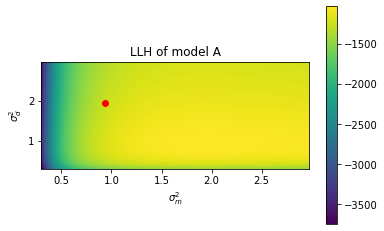

In [61]:
# define linearly space values of Lambda and sigma
Sigma_d = np.arange(0.3, 3.0, 0.025)
Sigma_m = np.arange(0.3, 3.0, 0.025)

# compute all possible pairs of parameter values (defining a grid)
LL, ss = np.meshgrid(Sigma_d, Sigma_m)

# compute LLH for each of these parameter sets
LLH = np.zeros(LL.shape)
for j in range(LL.shape[0]):
    for k in range(LL.shape[1]):
        LLH[j,k] = LogLikelihood_modelA(df_exp, Sigma_m[j], Sigma_d[k])

def show_LLA(LLH,sigma_d,sigma_m):
    im=plt.imshow(np.flipud(LLH), extent=[sigma_d[0],sigma_d[-1],sigma_m[0],sigma_m[-1]]);
    plt.gca().set_aspect(0.4)
    plt.ylabel('$\sigma_d^2$')
    plt.xlabel('$\sigma_m^2$')
    plt.colorbar(im)


# plot LLH profile
show_LLA(LLH, Sigma_d,Sigma_m)
plt.title('LLH of model A');
plt.plot(sigma_d_hat, sigma_m_hat, 'ro')

In [66]:

print('LLH for model A with optimal peramters', LogLikelihood_modelA(df_exp, 0.93, 1.94 ))
print('LLH for model Bwith optimal peramters', LogLikelihood_modelB(df_exp, 0.97, 0.22))

LLH for model A with optimal peramters -1036.3790687858868
LLH for model Bwith optimal peramters -1036.701845950021
